<a href="https://colab.research.google.com/github/aleksandr-del/kaggle-competitions/blob/main/house_prices_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Prices

![img](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

Попросите домовладельца описать свой дом мечты, и он вряд ли начнет свой рассказ с высоты потолка подвала дома и с расстояния до ближайшей железнодорожной станции. 

В представленных данных вы найдете доказательства, что на стоимость дома влияете не только количество спален или живая изгородь, но гораздо большее.

79 признаков описывают (почти) все аспекты жилых домов в городе Эймз штата Айова.

В этом [соревновании](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview) необходимо предсказать стоимость дома.



## Загрузка данных

Импортируем необходимые библиотеки, модули:

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline 
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

Загрузим обучающую выборку и сохраним ее в переменной `df`:

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI Start/Datasets/House Prices/train.csv')

Выведим первые 5 строк датасета:

In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Общая информация о датасете:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**Вывод**: в обучающей выборке 1 460 наблюдений, 79 признаков, целевой признак - `SalePrice`, наблюдаются пропуски.

## Предобработка и анализ данных

### Примеры категориальных и количественных признаков

#### MSSubClass

Класс или тип дома

Посмотрим на уникальные значения признака и их распределение:

In [34]:
df[['MSSubClass']].value_counts(dropna=False).reset_index(name='Количество домов')

,MSSubClass,Количество домов
0,20,536
1,60,299
2,50,144
3,120,87
4,30,69
5,160,63
6,70,60
7,80,58
8,90,52
9,190,30


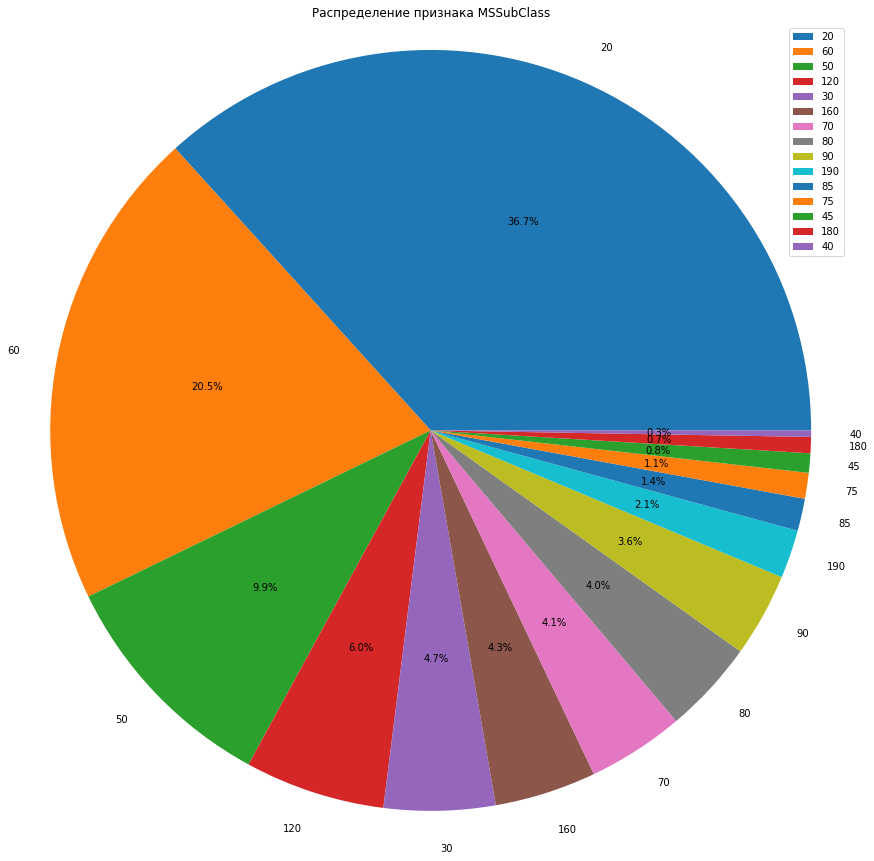

In [41]:
plt.figure(figsize=(15, 15))
plt.pie(df['MSSubClass'].value_counts(), 
            labels=df['MSSubClass'].value_counts().index, 
            autopct='%1.1f%%')
plt.axis('equal')
plt.title(f'Распределение признака MSSubClass')
plt.legend()
plt.show()

Признак `MSSubClass` принимает только дискретные значения и по сути является категориальным. Всего 15 уникальных значения. Наиболее частое (в 536 из 1460 случаев) значение - 20. Пропуски отсутствуют.



#### MSZoning

Классы зонирования

Посмотрим на уникальные значения признака и их распределение:

In [43]:
df[['MSZoning']].value_counts(dropna=False).reset_index(name='Количество домов')

,MSZoning,Количество домов
0,RL,1151
1,RM,218
2,FV,65
3,RH,16
4,C (all),10


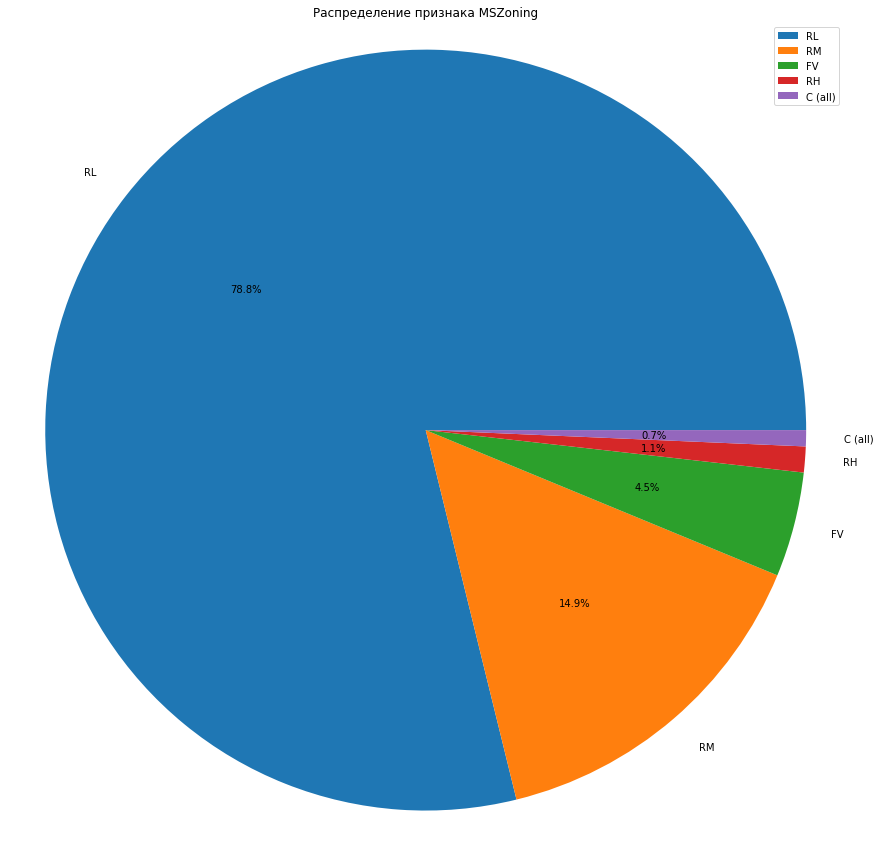

In [40]:
plt.figure(figsize=(15, 15))
plt.pie(df['MSZoning'].value_counts(), 
            labels=df['MSZoning'].value_counts().index, 
            autopct='%1.1f%%')
plt.axis('equal')
plt.title(f'Распределение признака MSZoning')
plt.legend()
plt.show()

Признак `MSZoning` категориальный. Всего 5 классов зонирования. Наиболее частое (в 1 151 из 1 460 наблюдений) зона - RL. Пропуски отсутствуют.



#### LotFrontage

Общая с публичным пространство граница домовладения (земельного участка), измеряется в футах.

Краткая описательная статистика:

In [44]:
df['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

Посмотрим на распределение признака:

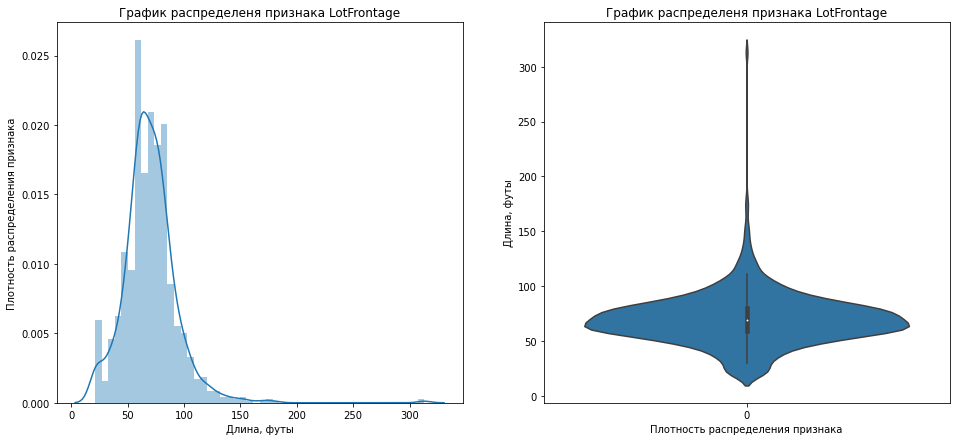

In [55]:
fig, ax = plt.subplots(1,2, figsize=(16,7))
sns.distplot(df['LotFrontage'], ax=ax[0])
ax[0].set(ylabel='Плотность распределения признака', 
          xlabel='Длина, футы',
          title='График распределеня признака LotFrontage')
sns.violinplot(df['LotFrontage'], ax=ax[1])
ax[1].set(ylabel='Длина, футы', 
          xlabel='Плотность распределения признака',
          title='График распределеня признака LotFrontage')
plt.show();

In [57]:
print(f"Количество пропусков: {df['LotFrontage'].isna().sum()}.")

Количество пропусков: 259.


Распределение признака `LotFrontage` близко к нормальному. Данные скошены право: наблюдаютсяо значения за границей 3-х стандартных отклонение (`>150`).

#### LotArea

Площадь домовладения, измеряется в квадратных футах

Краткая описательная статистика:

In [58]:
df['LotArea'].describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

Посмотрим на распределение признака:

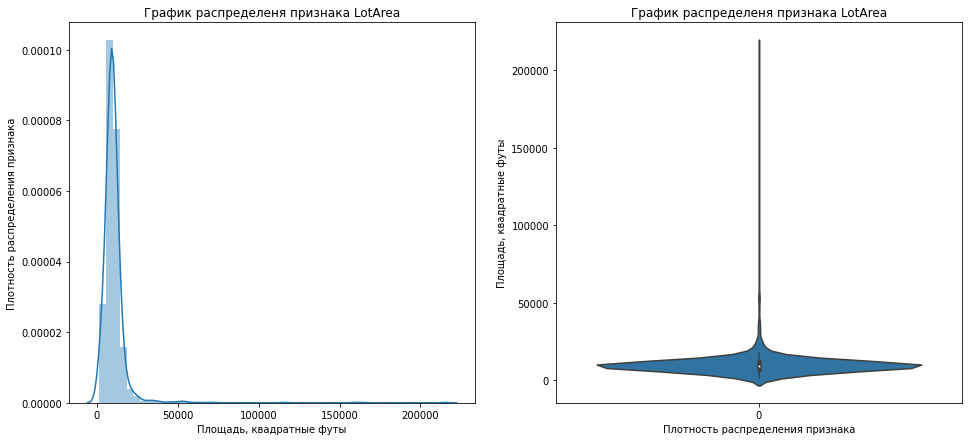

In [60]:
fig, ax = plt.subplots(1,2, figsize=(16,7))
sns.distplot(df['LotArea'], ax=ax[0])
ax[0].set(ylabel='Плотность распределения признака', 
          xlabel='Площадь, квадратные футы',
          title='График распределеня признака LotArea')
sns.violinplot(df['LotArea'], ax=ax[1])
ax[1].set(ylabel='Площадь, квадратные футы', 
          xlabel='Плотность распределения признака',
          title='График распределеня признака LotArea')
plt.show();

In [61]:
print(f"Количество пропусков: {df['LotArea'].isna().sum()}.")

Количество пропусков: 0.


Распределение признака `LotArea` близко к нормальному. Данные скошены право: наблюдаются значения за границей 3 стандартных отклонение (`>50000`).

#### Street

Тип ближайшей дороги

Посмотрим на уникальные значения признака и их распределение:

In [62]:
df[['Street']].value_counts(dropna=False).reset_index(name='Количество домов')

,Street,Количество домов
0,Pave,1454
1,Grvl,6


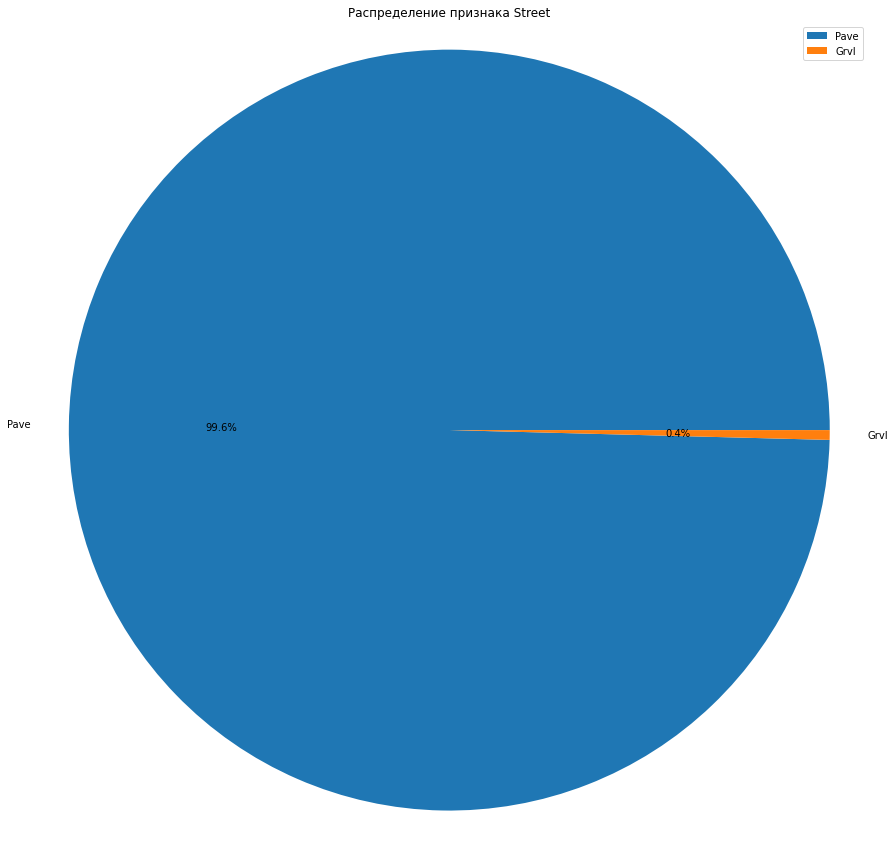

In [63]:
plt.figure(figsize=(15, 15))
plt.pie(df['Street'].value_counts(), 
            labels=df['Street'].value_counts().index, 
            autopct='%1.1f%%')
plt.axis('equal')
plt.title(f'Распределение признака Street')
plt.legend()
plt.show()

Признак `Street` является категориальным. Всего 2 уникальных значения. У 99,6% домов обучающей выборки ближайшие дороги заасфальтированы. Пропуски отсутствуют.



#### Alley

Тип подъздных путей

Посмотрим на уникальные значения признака и их распределение:

In [65]:
df[['Alley']].value_counts(dropna=False).reset_index(name='Количество домов')

,Alley,Количество домов
0,NaN,1369
1,Grvl,50
2,Pave,41


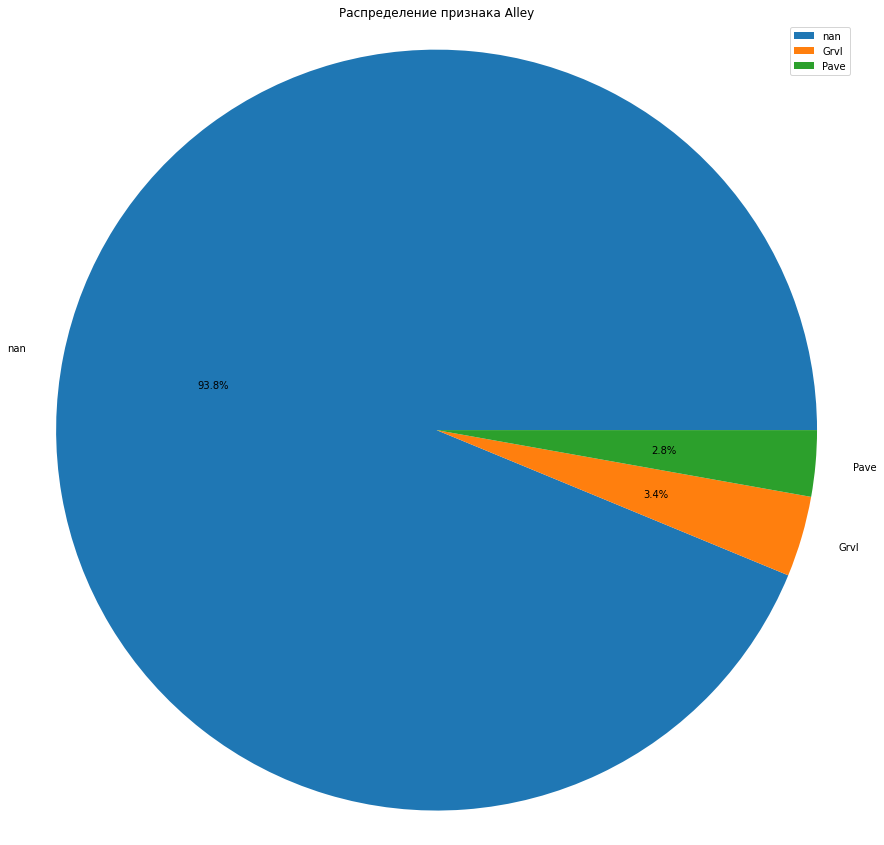

In [66]:
plt.figure(figsize=(15, 15))
plt.pie(df['Alley'].value_counts(dropna=False), 
            labels=df['Alley'].value_counts(dropna=False).index, 
            autopct='%1.1f%%')
plt.axis('equal')
plt.title(f'Распределение признака Alley')
plt.legend()
plt.show()

Признак `Alley` является категориальным. Всего 2 уникальных значения. У 93,8% домовладений подъездные пути отсутствуют: у них прямой доступ на проезжую часть основной дороги.

### Количественные признаки с пропусками

Выведим признаки с пропусками, у которых числовой тип данных:

In [95]:
df.select_dtypes(exclude='object').isna().sum()[df.select_dtypes(exclude='object').isna().sum() > 0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

Краткая описательная статистика признака `MasVnrArea`:

In [96]:
df['MasVnrArea'].describe()

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

Пропуски признака `MasVnrArea` будем заполнять медианным значением.

Убедимся, что пропуски в признаке `GarageYrBlt` только у тех домовладений, у которых отсуствует гараж (пропуск в признаке `GarageType`)

In [107]:
df[df['GarageType'].isna()].index == df[df['GarageYrBlt'].isna()].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

## Обучение

### Линейная регрессия c регуляризацией Lasso

Создадим список категориальных признаков:

In [114]:
cat_features = df.select_dtypes(include='object').columns.tolist()
cat_features

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

Создадим список количественных признаков, предварительно удалив из него `Id` и `SalePrice`:

In [115]:
num_features = df.drop(columns=['Id', 'SalePrice']).select_dtypes(exclude='object').columns.tolist()
num_features

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

Создадим переменную `y` с наименованием целевого признака:

In [116]:
 y = 'SalePrice'
 y

'SalePrice'

Создадим конвейер подготовки количественных признаков. Пропущенные значения будут заполняться медианой, значения признаков будут нормализованы:

In [121]:
num_transformer = make_pipeline(SimpleImputer(strategy='median'),
                                StandardScaler())

Создадим конвейер подготовки качественных признаков. Пропущенные значения будут заполняться константым `no`, категориальные значения будут преобразованы в числовые:

In [119]:
cat_transformer = make_pipeline(SimpleImputer(strategy='constant', 
                                              fill_value='no'),
                                OneHotEncoder(handle_unknown='ignore',
                                              sparse=False))

Создадим preprocessor для подготовки всех данных:

In [122]:
preprocessor = ColumnTransformer([('num', num_transformer, num_features),
                                  ('cat', cat_transformer, cat_features)],
                                 verbose_feature_names_out=False)

Создадим финальный конвейер для подготовки данных и обучения алгоритма:

In [123]:
alg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', Lasso(random_state=42))])

Посмотрим на этапа финального конвейера:

In [125]:
alg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndF...
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual', ...])],
                                   verbose_feature_names_out=False)),
                ('estimator', Lasso(random_state=42))])

Создадим сетку гиперпараметров:

In [138]:
parameters = {
    'estimator__alpha': [0, 0.01, 0.1, 0.5, 0.7, 1, 2, 5, 10],
    'estimator__max_iter': [300, 500, 1000, 2000, 5000]
}

In [139]:
gs = GridSearchCV(alg,
                  parameters,
                  cv=5,
                  scoring='r2',
                  n_jobs=2)

Перебираем гиперпараметры:

In [140]:
gs.fit(df, df[y])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'BsmtFinSF2',
                                                                          'BsmtUnfSF',
                                                                          'T...
                                                                          'Foundation',
                                                                          'BsmtQual',
                                                                          'BsmtCond',
                                                                          'BsmtExposure',
                                                                          'BsmtFinType1',
                                                                          'BsmtFinType2',
                                                                          'Heating',
                                                                          'HeatingQC',
                                                                          'CentralAir',
                                                                          'Electrical',
                                                                          'KitchenQual', ...])],
                                                          verbose_feature_names_out=False)),
                                       ('estimator', Lasso(random_state=42))]),
             n_jobs=2,
             param_grid={'estimator__alpha': [0, 0.01, 0.1, 0.5, 0.7, 1, 2, 5,
                                              10],
                         'estimator__max_iter': [300, 500, 1000, 2000, 5000]},
             scoring='r2')

Лучшие гиперпараметры модели:

In [141]:
gs.best_params_

{'estimator__alpha': 10, 'estimator__max_iter': 5000}

Лучшая метрика R2 модели:

In [142]:
gs.best_score_

0.8162187904437358

### Градиентный бустинг

Реализуем класс градиентного бустинга:

In [156]:
class MyGradientBoosting():
    def __init__(self, lr=0.01, iters=1000, max_depth=32):
        self.lr = lr
        self.iters = iters
        self.max_depth = max_depth
        self.models_ = None
        self.constant_prediction_ = None
        self.R2_ = None

    def fit(self, X, y):
        X = X.values
        y = y.values
        prediction = np.full((y.shape), np.mean(y)) # инициализируем модель константным предсказанием: среднее значение таргета обучающей выборки
        models = [] # в этом списке будем хранить модели Решающего дерева
        R2 = [] # в этом списке будем хранить значение R2 каждой итерации

        for _ in range(self.iters):
            residual = y - prediction # считаем остатки
            model = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42) # инициализируем модель Решающего дерева
            model.fit(X, residual) # обучаемся на остатках
            prediction += model.predict(X) * self.lr # корректируем константное предсказание, компенсируя остатки
            models.append(model) # сохраняем модель в список моделей
            R2.append(r2_score(y, prediction)) # сохраняем метрику R2
           
        self.models_ = models
        self.constant_prediction_ = np.mean(y)
        self.R2_ = R2

    def predict(self, X):
        X = X.values
        prediction = np.full((X.shape[0]), self.constant_prediction_)

        for model in self.models_:
            prediction += model.predict(X) * self.lr
    
        return prediction

Инициализируем объект класса `MyGradientBoosting` c глубиною каждого дерева решений, равной 4, 1 000 итераций и скоростью обучения, равной 0.01:

In [166]:
mgb = MyGradientBoosting(max_depth=4, iters=1000, lr=0.01)

Подготовим обучающую выборку с помощью `preprocessor`:

In [158]:
prep_df = pd.DataFrame(preprocessor.fit_transform(df))

Так как класс `MyGradientBoosting` не принадлежит библиотеке `scikit-learn` и в нем не реализован метод `get_params`, кросс-валидацию градиентного бустинга проведем с помощью `KFold`:

In [167]:
cv = KFold(n_splits=5)
R2 = []

for train_index, valid_index in cv.split(prep_df):
    X_train, y_train = prep_df.loc[train_index], df[y].reset_index(drop=True).loc[train_index]
    X_valid, y_valid = prep_df.loc[valid_index], df[y].reset_index(drop=True).loc[valid_index]
    
    mgb.fit(X_train, y_train)
    pred_valid = mgb.predict(X_valid)
    R2.append(r2_score(y_valid, pred_valid))

print(f'Лучший результат R2 на обучающей выборке: {np.max(R2)}')

Лучший результат R2 на обучающей выборке: 0.9093259924052511


### Вывод

Лучший результат продемонстрировал алгоритм градиентного бустинга

## Submission для соревнования

Скачаем тестовую выборку:

In [168]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI Start/Datasets/House Prices/test.csv')

Выведим первые 5 строк датасета:

In [169]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Подготовим признаки тестовой выборки:

In [172]:
prep_test = pd.DataFrame(preprocessor.transform(test))

Предсказание модели градиентного бустинга на тестовой выборке:

In [173]:
y_test = mgb.predict(prep_test)

Запишем предсказания в столбец `SalePrice`

In [175]:
test['SalePrice'] = y_test

Запишем таблицу в файл для отправки на Kaggle:

In [176]:
test[['Id', 'SalePrice']].to_csv('submission.csv', index=None)

### Результаты соревнования

#### Решение было подготовлено 22 марта 2023 г. 1 337 место из 4 255 на доске лидеров соревнования со `score = 0.13462` 